In [300]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['image.cmap'] = 'inferno'

import os 
from os.path import join as pjoin
import glob

def imread(imgpath):
    return cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)

def imshow(img, cmap=None):
    plt.title(img.shape)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')

# Init 8 points and their colors

In [310]:
pts1 = np.arange(16).reshape(8, 2)
pts1[0,:] = (295, 358)
pts1[1,:] = (233, 248)
pts1[2,:] = (437, 354)
# pts1[2,:] = (280, 635)
pts1[3,:] = (436, 405)
pts1[4,:] = (362, 489)
pts1[5,:] = (257, 482)
pts1[6,:] = (285, 565)
pts1[7,:] = (307, 440)

pts2 = np.arange(16).reshape(8, 2)
pts2[0,:] = (459, 349)
pts2[1,:] = (324, 231)
pts2[2,:] = (599, 358)
# pts2[2,:] = (406, 641)
pts2[3,:] = (595, 407)
pts2[4,:] = (536, 493)
pts2[5,:] = (361, 476)
pts2[6,:] = (417, 565)
pts2[7,:] = (493, 432)

pts3 = np.arange(16).reshape(8, 2)
pts3[0,:] = (998, 402)
pts3[1,:] = (752, 287)
pts3[2,:] = (1160, 424)
pts3[3,:] = (1172, 495)
pts3[4,:] = (1120, 595)
pts3[5,:] = (823, 595)
pts3[6,:] = (939, 704)
pts3[7,:] = (1077, 503)

colors = []
for i in range (len(pts1)):
    colors.append(tuple(np.random.randint(0,255,3).tolist()))

# Show images and selected keypoints

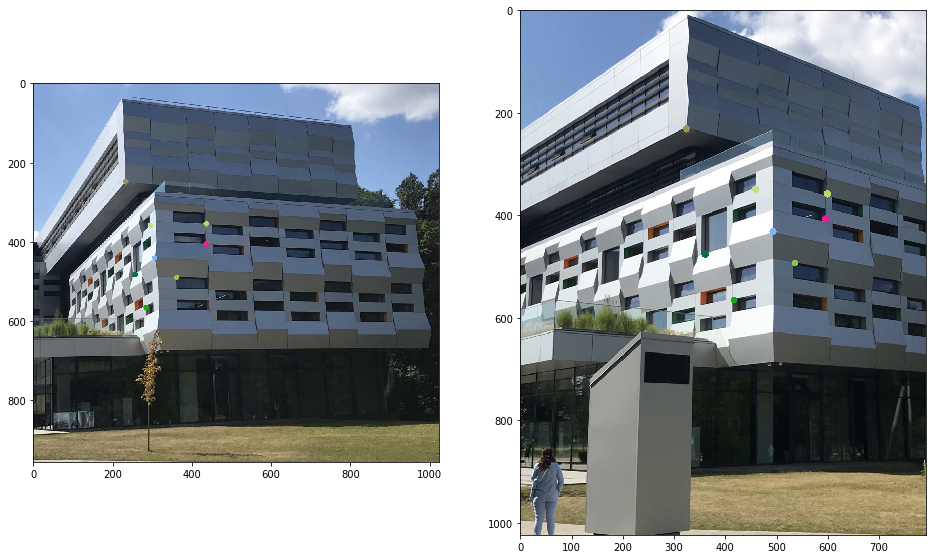

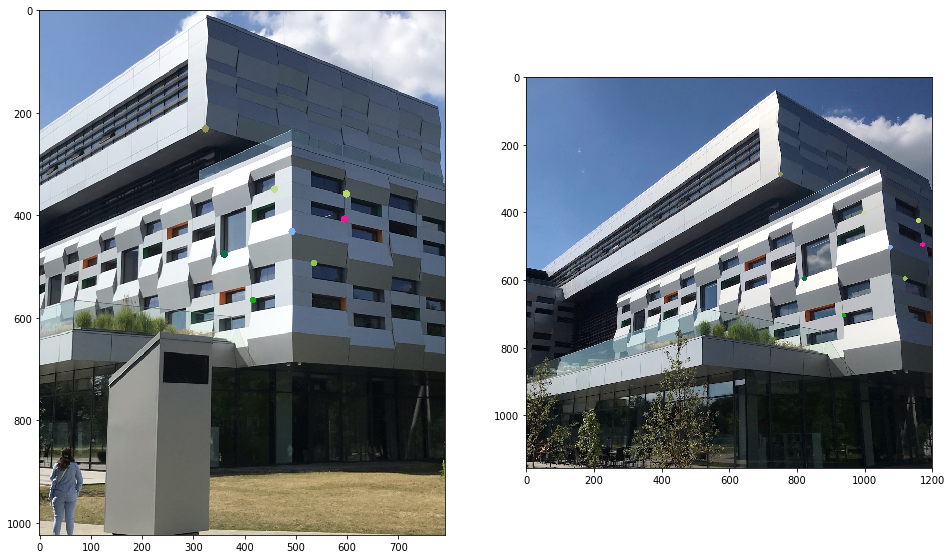

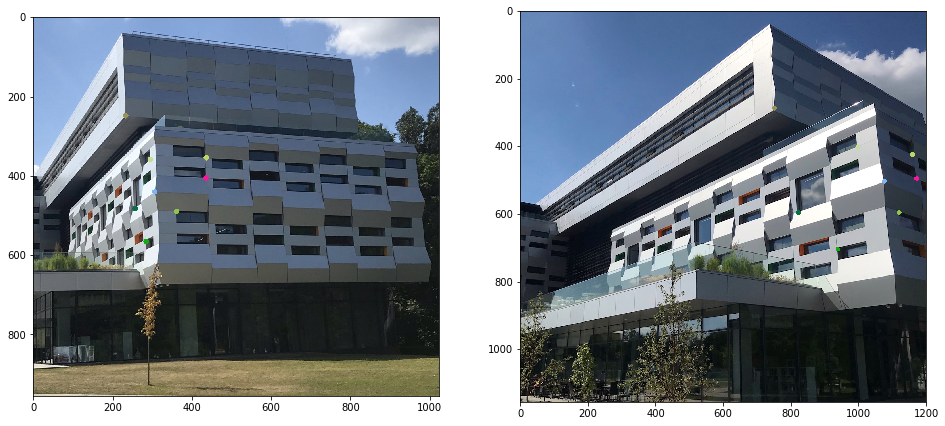

In [312]:
imgdir = 'data'
img_name1 = 'IMG_3929_cropped'
img_name2 = 'IMG_3930_cropped'
img_name3 = 'IMG_3933_cropped'
filename1 = pjoin(imgdir, '{}.jpg'.format(img_name1))
filename2 = pjoin(imgdir, '{}.jpg'.format(img_name2))
filename3 = pjoin(imgdir, '{}.jpg'.format(img_name3))

img1 = imread(filename1)  
img2 = imread(filename2)
img3 = imread(filename3) 

for p1,p2,p3,color in zip(pts1,pts2, pts3, colors):
    img1 = cv2.circle(img1,tuple(p1),7,color,-1)
    img2 = cv2.circle(img2,tuple(p2),7,color,-1)
    img3 = cv2.circle(img3,tuple(p3),7,color,-1)

plt.subplot(121),plt.imshow(img1)
plt.subplot(122),plt.imshow(img2)
plt.show()
plt.subplot(121),plt.imshow(img2)
plt.subplot(122),plt.imshow(img3)
plt.show()
plt.subplot(121),plt.imshow(img1)
plt.subplot(122),plt.imshow(img3)
plt.show()

# Find fundamental matrix with opencv

In [313]:
F_opencv1_2, _ = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)
F_opencv2_3, _ = cv2.findFundamentalMat(pts2, pts3, cv2.FM_LMEDS)
F_opencv1_3, _ = cv2.findFundamentalMat(pts1, pts3, cv2.FM_LMEDS)

## Draw epilines with fundamental matrix from opencv

In [314]:
def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c,_ = img1.shape
    i = 0
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = colors[i]
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,4)
        img1 = cv2.circle(img1,tuple(pt1),10,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),10,color,-1)
        i+=1

    return img1,img2

def draw_epilines(img1, img2, pts1, pts2, F):
    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
    plt.subplot(121),plt.imshow(img5)
    plt.subplot(122),plt.imshow(img3)
    plt.show()

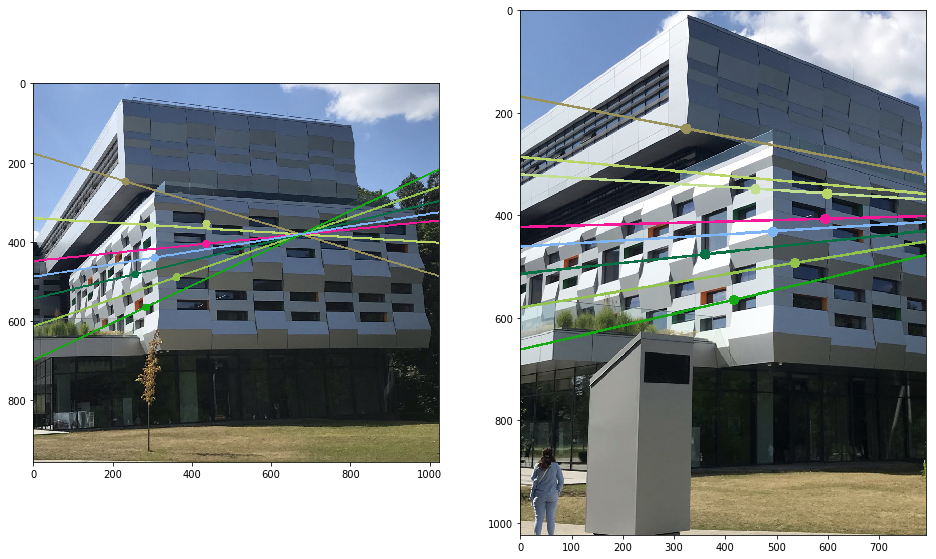

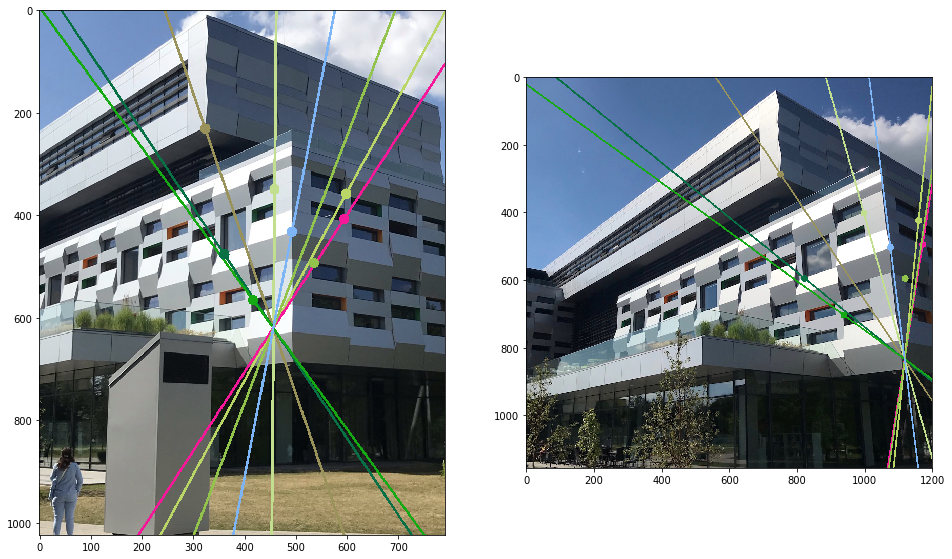

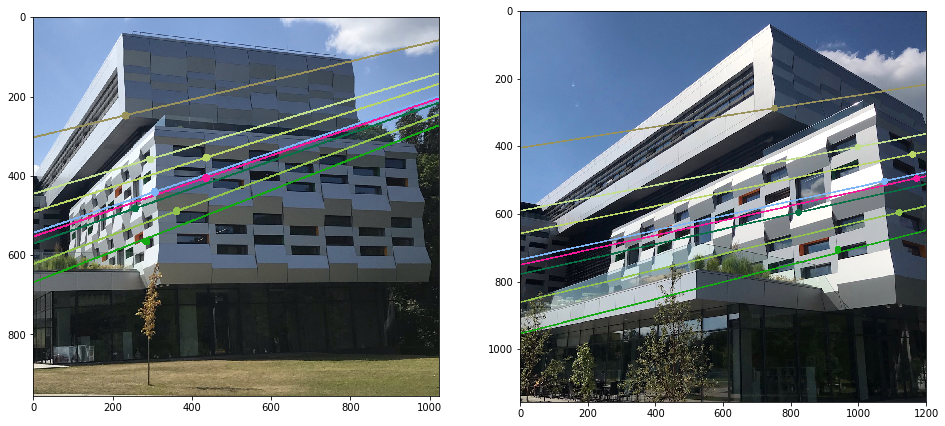

In [315]:
draw_epilines(img1 = imread(filename1), 
              img2 = imread(filename2), 
              pts1 = pts1,
              pts2 = pts2,
              F = F_opencv1_2)

draw_epilines(img1 = imread(filename2), 
              img2 = imread(filename3), 
              pts1 = pts2,
              pts2 = pts3,
              F = F_opencv2_3)

draw_epilines(img1 = imread(filename1), 
              img2 = imread(filename3), 
              pts1 = pts1,
              pts2 = pts3,
              F = F_opencv1_3)

# Find fundamental matrix with custom realization

In [316]:
# some code regarding 
# https://github.com/marktao99/python/blob/master/CVP/samples/sfm.py

# http://pydoc.net/ippe/0.0.1/ippe.homo2d/ 
# based on original matlab function
# https://www.mathworks.com/matlabcentral/fileexchange/54544-normalise2dpts-pts

def normalise2dpts(pts):
    """
    Function translates and normalises a set of 2D homogeneous points 
    so that their centroid is at the origin and their mean distance from 
    the origin is sqrt(2).  This process typically improves the
    conditioning of any equations used to solve homographies, fundamental
    matrices etc.
       
       
    Inputs:
    pts: 3xN array of 2D homogeneous coordinates
   
    Returns:
    newpts: 3xN array of transformed 2D homogeneous coordinates.  The
            scaling parameter is normalised to 1 unless the point is at
            infinity. 
    T: The 3x3 transformation matrix, newpts = T*pts
    """
    if pts.shape[0] != 3:
        print("Input shoud be 3")

    finiteind = np.nonzero(abs(pts[2,:]) > np.spacing(1));

    if len(finiteind[0]) != pts.shape[1]:
        print('Some points are at infinity')
    
    dist = []
    for i in finiteind:
        pts[0,i] = pts[0,i]/pts[2,i]
        pts[1,i] = pts[1,i]/pts[2,i]
        pts[2,i] = 1;

        c = np.mean(pts[0:2,i].T, axis=0).T          

        newp1 = pts[0,i]-c[0]
        newp2 = pts[1,i]-c[1]
    
        dist.append(np.sqrt(newp1**2 + newp2**2))

    meandist = np.mean(dist[:])
    
    scale = np.sqrt(2)/meandist
    
    T = np.array([[scale, 0, -scale*c[0]], [0, scale, -scale*c[1]], [0, 0, 1]])
    
    newpts = T.dot(pts)

    return [newpts, T]

def compute_fundamental(x1,x2):
    if x2.shape[0] != x1.shape[0]:
        raise ValueError("Number of points don't match.")
        
    n = x1.shape[0]
    
    # transform [x,y] to homogenous [x,y,1]
    x1 = np.hstack((x1,np.ones((x1.shape[0],1))))
    x2 = np.hstack((x2,np.ones((x2.shape[0],1))))
    
    # Normalise points
    x1, T1 = normalise2dpts(x1.T)
    x2, T2 = normalise2dpts(x2.T)
        
    A = np.zeros((n,9))
    for i in range(n):
        A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i],
                x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i],
                x2[0,i], x2[1,i], 1 ]
            
    # compute linear least square solution
    U,S,V = np.linalg.svd(A)
    F = (V[-2].reshape(3,3))

    # Force F to be rank 2 matrix
    U,D,V = np.linalg.svd(F)
    D[2] = 0
    F = np.dot(U,np.dot(np.diag(D),V))
    
    # Denormalise
    F = np.dot(T2.T, np.dot(F, T1))
    
    return F/F[2,2]

In [317]:
F_custom1_2 = compute_fundamental(pts1, pts2)
F_custom2_3 = compute_fundamental(pts2, pts3)
F_custom1_3 = compute_fundamental(pts1, pts3)

## Compare fundamental matrices

In [318]:
print(F_custom1_2 - F_opencv1_2)
print()
print(F_custom2_3 - F_opencv2_3)
print()
print(F_custom1_3 - F_opencv1_3)

[[ 1.90087498e-05  3.41615149e-04 -1.43262584e-01]
 [-6.11132906e-04 -9.89319721e-06  4.15504108e-01]
 [ 2.19886106e-01 -3.87464441e-01  0.00000000e+00]]

[[-2.79044621e-05  5.62536997e-05 -2.22887696e-02]
 [-4.36739318e-05 -1.53427753e-05  2.94997046e-02]
 [ 6.78874785e-02 -4.98351397e-02  0.00000000e+00]]

[[ 1.29709481e-06  2.88055160e-06  1.40444309e-04]
 [-7.13920862e-06 -5.00112863e-06  1.40158173e-02]
 [-1.92055464e-03 -1.41841882e-02  0.00000000e+00]]


## Draw epilines from fundamental matrix from custom implementation

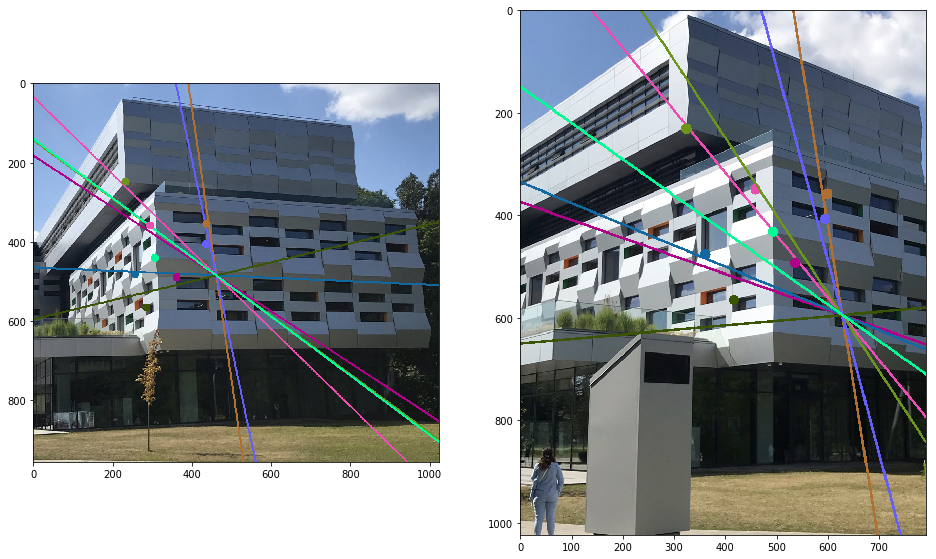

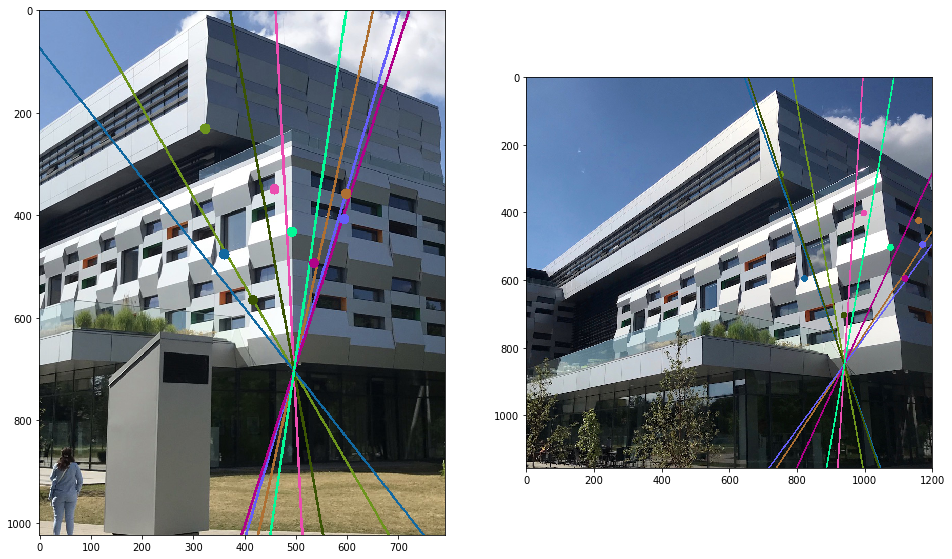

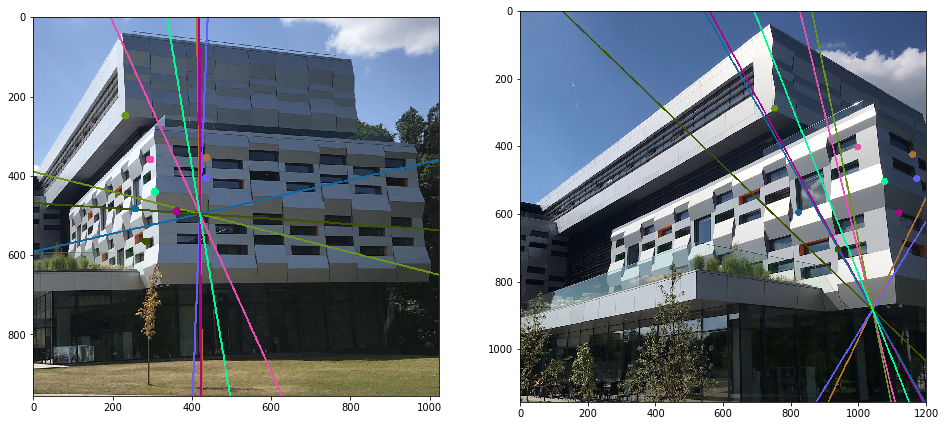

In [309]:
draw_epilines(img1 = imread(filename1), 
              img2 = imread(filename2), 
              pts1 = pts1,
              pts2 = pts2,
              F = F_custom1_2)

draw_epilines(img1 = imread(filename2), 
              img2 = imread(filename3), 
              pts1 = pts2,
              pts2 = pts3,
              F = F_custom2_3)

draw_epilines(img1 = imread(filename1), 
              img2 = imread(filename3), 
              pts1 = pts1,
              pts2 = pts3,
              F = F_custom1_3)